In [1]:
!pip install surprise

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 772.0/772.0 kB 11.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.3-cp310-cp310-linux_x86_64.whl size=2811622 sha256=21ab8844f935d3a2df96cec1dc35bdae70c3c36075b113cd9c7927dff0086635
  Stored in directory: /root/.cache/pip/wheels/a5/ca/a8/4e28def53797fdc4363ca4af740db15a9c2f1595ebc51fb445
Successfully built scikit-surprise


In [2]:
# Used to ignore the warning given as output of the code
import warnings
warnings.filterwarnings('ignore')

# Basic libraries of python for numeric and dataframe computations
import numpy as np
import pandas as pd

# Basic library for data visualization
import matplotlib.pyplot as plt

# Slightly advanced library for data visualization
import seaborn as sns

# A dictionary output that does not raise a key error
from collections import defaultdict

# A performance metrics in surprise
from surprise import accuracy

# Class is used to parse a file containing ratings, data should be in structure - user ; item ; rating
from surprise.reader import Reader
# Class for loading datasets
from surprise.dataset import Dataset

# For model tuning model hyper-parameters
from surprise.model_selection import GridSearchCV

# For splitting the rating data in train and test dataset
from surprise.model_selection import train_test_split

# For implementing similarity based recommendation system
from surprise.prediction_algorithms.knns import KNNBasic

# For implementing matrix factorization based recommendation system
from surprise.prediction_algorithms.matrix_factorization import SVD

# For implementing cross validation
from surprise.model_selection import KFold

In [3]:
rating = pd.read_csv('ratings_Electronics.csv', names=['user_id', 'item_id', 'rating', 'timestamp'])
rating.drop('timestamp', axis = 1)



,user_id,item_id,rating
0,AKM1MP6P0OYPR,0132793040,5.0
1,A2CX7LUOHB2NDG,0321732944,5.0
2,A2NWSAGRHCP8N5,0439886341,1.0
3,A2WNBOD3WNDNKT,0439886341,3.0
4,A1GI0U4ZRJA8WN,0439886341,1.0
...,...,...,...
7824477,A2YZI3C9MOHC0L,BT008UKTMW,5.0
7824478,A322MDK0M89RHN,BT008UKTMW,5.0
7824479,A1MH90R0ADMIK0,BT008UKTMW,4.0
7824480,A10M2KEFPEQDHN,BT008UKTMW,4.0


In [4]:
rating.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7824482 entries, 0 to 7824481
Data columns (total 4 columns):
 #   Column     Dtype  
---  ------     -----  
 0   user_id    object 
 1   item_id    object 
 2   rating     float64
 3   timestamp  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 238.8+ MB


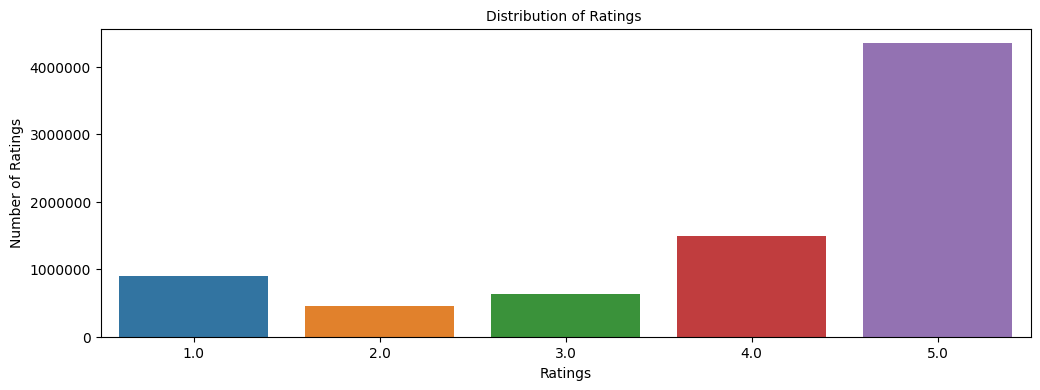

In [5]:
plt.figure(figsize = (12, 4))
sns.countplot(x ='rating', data = rating)
plt.tick_params(labelsize = 10)
plt.title("Distribution of Ratings ", fontsize = 10)
plt.xlabel("Ratings", fontsize = 10)
plt.ylabel("Number of Ratings", fontsize = 10)
plt.ticklabel_format(useOffset=False, style='plain', axis='y')
plt.show()

In [6]:
df = rating.copy()

Here, We will be taking users who have given at least 50 rating, and the products who has at least 5 rating, as when we shop online we prefer to have some number of rating of a product.


In [7]:
# Get the column containing the users
users = rating.user_id
# Create a dictionary from users to their number of ratings
ratings_count = dict()
for user in users:
    # If we already have the user, just add 1 to their rating count
    if user in ratings_count:
        ratings_count[user] += 1
    # Otherwise, set their rating count to 1
    else:
        ratings_count[user] = 1

In [8]:
# We want our users to have at least 50 ratings to be considred
RATINGS_CUTOFF = 50
remove_users = []
for user, num_ratings in ratings_count.items():
    if num_ratings < RATINGS_CUTOFF:
        remove_users.append(user)
rating = rating.loc[~rating.user_id.isin(remove_users)]

In [9]:
rating.shape

(125871, 4)

In [10]:
# Get the column containing the users
items = rating.item_id
# Create a dictionary from users to their number of ratings
ratings_count = dict()
for item in items:
    # If we already have the user, just add 1 to their rating count
    if item in ratings_count:
        ratings_count[item] += 1
    # Otherwise, set their rating count to 1
    else:
        ratings_count[item] = 1


In [11]:
# We want our item to have at least 5 ratings to be considred
RATINGS_CUTOFF = 5
remove_items = []
for item, num_ratings in ratings_count.items():
    if num_ratings < RATINGS_CUTOFF:
        remove_items.append(item)
rating = rating.loc[~rating.item_id.isin(remove_items)]

In [12]:
rating.shape

(65290, 4)

In [13]:
rating['user_id'].nunique()

1540

In [14]:
rating.groupby(['user_id', 'item_id']).count()

rating  timestamp
user_id        item_id                      
A100UD67AHFODS B00004Z5M1       1          1
               B0001D3K8A       1          1
               B000233WJ6       1          1
               B0002KVQBA       1          1
               B0002SQ2P2       1          1
...                           ...        ...
AZOK5STV85FBJ  B005PQTYHE       1          1
               B006MPRFJQ       1          1
               B00AANMVNQ       1          1
               B00B25P27S       1          1
               B00FB2XNCE       1          1

[65290 rows x 2 columns]

In [15]:
rating.groupby(['user_id', 'item_id']).count()['rating'].sum()

65290

In [16]:
rating['item_id'].value_counts()

B0088CJT4U    206
B003ES5ZUU    184
B000N99BBC    167
B007WTAJTO    164
B00829TIEK    149
             ... 
B00368CDH6      5
B0036AZA6A      5
B0036E8V08      5
B0036QL1JY      5
B00LGQ6HL8      5
Name: item_id, Length: 5689, dtype: int64

Text(0, 0.5, 'Count')

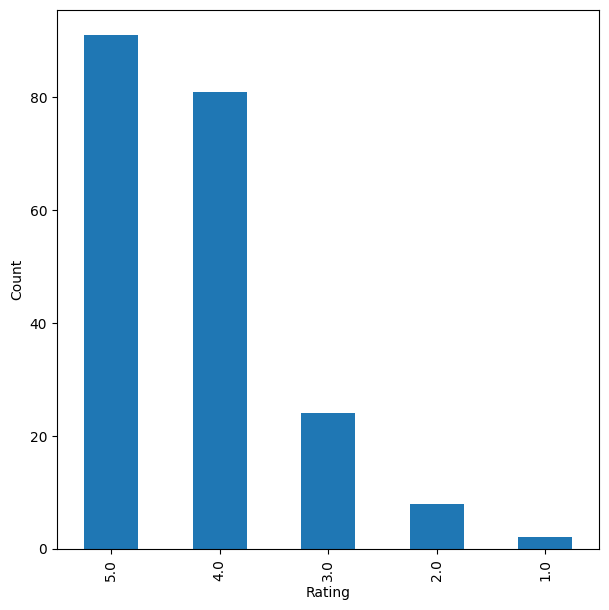

In [17]:
#Plotting distributions of ratings for 74 interactions with itemid B0088CJT4U
plt.figure(figsize=(7,7))

rating[rating['item_id'] == 'B0088CJT4U']['rating'].value_counts().plot(kind='bar')

plt.xlabel('Rating')

plt.ylabel('Count')


In [18]:
count_interactions = rating.groupby('user_id').count()['item_id']
count_interactions

user_id
A100UD67AHFODS     53
A100WO06OQR8BQ     77
A105S56ODHGJEK     58
A105TOJ6LTVMBG     32
A10AFVU66A79Y1     47
                 ... 
AZBXKUH4AIW3X      22
AZCE11PSTCH1L      23
AZMY6E8B52L2T     105
AZNUHQSHZHSUE      30
AZOK5STV85FBJ      14
Name: item_id, Length: 1540, dtype: int64

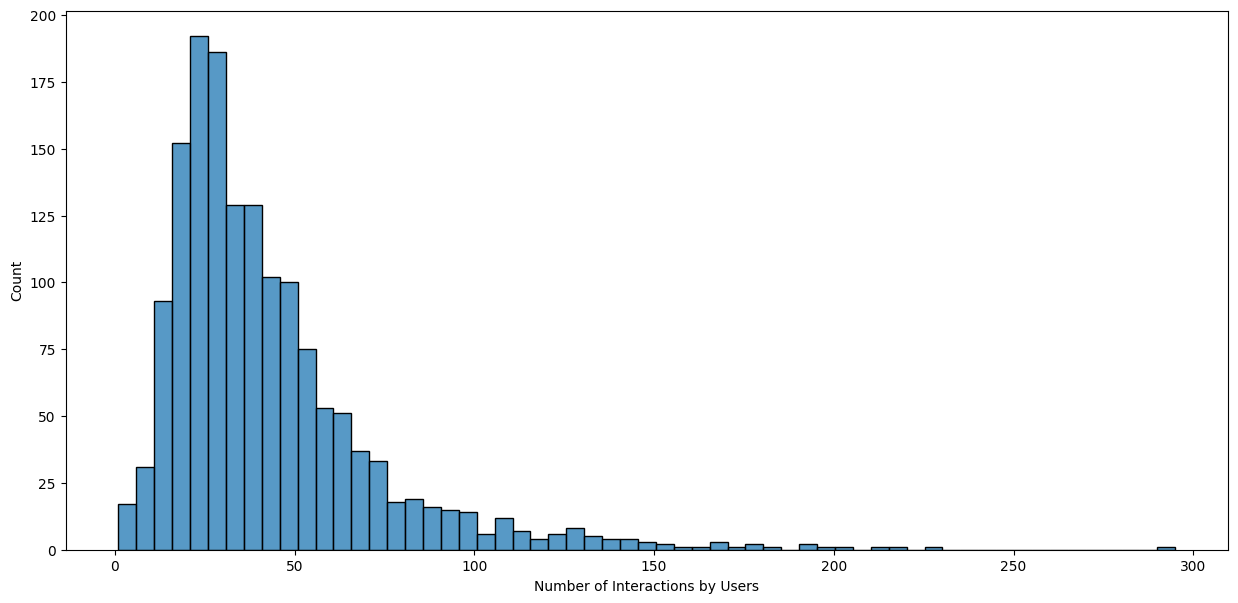

In [19]:
plt.figure(figsize=(15,7))


sns.histplot(count_interactions)

plt.xlabel('Number of Interactions by Users')

plt.show()

**Model 1**: Rank Based Recommendation System

In [20]:
#Calculating average ratings
average_rating = rating.groupby('item_id').mean()['rating']

#Calculating the count of ratings
count_rating = rating.groupby('item_id').count()['rating']

#Making a dataframe with the count and average of ratings
final_rating = pd.DataFrame({'avg_rating':average_rating, 'rating_count':count_rating})

In [21]:
def top_n_items(data,n,min_interaction=30):
   recommendations = final_rating[final_rating['rating_count'] >= min_interaction].sort_values('avg_rating', ascending=False)
   return recommendations.index[:n]

In [22]:
list(top_n_items(final_rating, 5 , min_interaction=50))

['B001TH7GUU', 'B003ES5ZUU', 'B0019EHU8G', 'B006W8U2MU', 'B000QUUFRW']

**Collaborative Filtering Based Recommendation system**

In [23]:
from sklearn.preprocessing import LabelEncoder
df=rating[['user_id','item_id']].apply(LabelEncoder().fit_transform)
df['rating']=rating['rating']
df.tail()

,user_id,item_id,rating
7824423,870,5688,5.0
7824424,187,5688,5.0
7824425,462,5688,5.0
7824426,163,5688,5.0
7824427,664,5688,5.0


Making the dataset into surprise dataset and splitting it into train and test set

In [24]:
# instantiating Reader scale with expected rating scale
reader = Reader(rating_scale=(0, 5))

# loading the rating dataset
data = Dataset.load_from_df(df[['user_id', 'item_id', 'rating']], reader)

# splitting the data into train and test dataset
trainset, testset = train_test_split(data, test_size=0.7, random_state=42)

First baseline similary based recommendation system using cosine similarity and KNN

In [25]:
algo_knn = {'name': 'cosine',
               'user_based': True}
algo_knn_user = KNNBasic(algo_knn = algo_knn,verbose=False, random_state=1)
algo_knn_user.fit(trainset)
accuracy.rmse(algo_knn_user.test(testset))

RMSE: 1.0581


1.0580923992331106

In [26]:
algo_knn_user.predict(0,3906, r_ui=4, verbose=True)

user: 0          item: 3906       r_ui = 4.00   est = 4.29   {'was_impossible': True, 'reason': 'Not enough neighbors.'}


Prediction(uid=0, iid=3906, r_ui=4, est=4.291366722826364, details={'was_impossible': True, 'reason': 'Not enough neighbors.'})

 Predicting rating for the same userId=0 but for a item which this user has not interacted before i.e. itemId = 100

In [27]:
algo_knn_user.predict(0,100, verbose=True)

user: 0          item: 100        r_ui = None   est = 4.00   {'actual_k': 1, 'was_impossible': False}


Prediction(uid=0, iid=100, r_ui=None, est=4.0, details={'actual_k': 1, 'was_impossible': False})

Improving similarity based recommendation system by tuning its hyper-parameters

In [28]:
# Setting up parameter grid to tune the hyperparameters
param_grid = {'k': [20, 30, 40], 'min_k': [3, 6, 9],
              'sim_options': {'name': ['msd', 'cosine'],
                              'user_based': [True]}
              }
# Performing 3-fold cross validation to tune the hyperparameters
gs = GridSearchCV(KNNBasic, param_grid, measures=['rmse', 'mae'], cv=3, n_jobs=-1)

# fitting the data
gs.fit(data)

# best RMSE score
print(gs.best_score['rmse'])

# combination of parameters that gave the best RMSE score
print(gs.best_params['rmse'])

0.9709430074881397
{'k': 40, 'min_k': 6, 'sim_options': {'name': 'msd', 'user_based': True}}


In [29]:
results_df = pd.DataFrame.from_dict(gs.cv_results)
results_df.head()

,split0_test_rmse,split1_test_rmse,split2_test_rmse,mean_test_rmse,std_test_rmse,rank_test_rmse,split0_test_mae,split1_test_mae,split2_test_mae,mean_test_mae,std_test_mae,rank_test_mae,mean_fit_time,std_fit_time,mean_test_time,std_test_time,params,param_k,param_min_k,param_sim_options
0,0.971196,0.982860,0.983439,0.979165,0.005640,18,0.724646,0.730975,0.731372,0.728998,0.003081,1,0.196254,0.045585,0.898595,0.022553,"{'k': 20, 'min_k': 3, 'sim_options': {'name': ...",20,3,"{'name': 'msd', 'user_based': True}"
1,0.968484,0.979208,0.981621,0.976438,0.005710,11,0.727049,0.733291,0.734391,0.731577,0.003233,6,0.269745,0.043529,0.929624,0.049449,"{'k': 20, 'min_k': 3, 'sim_options': {'name': ...",20,3,"{'name': 'cosine', 'user_based': True}"
2,0.963916,0.973870,0.975411,0.971066,0.005094,3,0.740336,0.747191,0.748635,0.745387,0.003620,7,0.134605,0.022271,0.876915,0.023153,"{'k': 20, 'min_k': 6, 'sim_options': {'name': ...",20,6,"{'name': 'msd', 'user_based': True}"
3,0.964339,0.973708,0.976369,0.971472,0.005160,6,0.743234,0.749715,0.751390,0.748113,0.003517,12,0.216215,0.014900,0.893737,0.047392,"{'k': 20, 'min_k': 6, 'sim_options': {'name': ...",20,6,"{'name': 'cosine', 'user_based': True}"
4,0.968183,0.980273,0.980905,0.976454,0.005854,12,0.752813,0.760703,0.762123,0.758546,0.004095,13,0.219012,0.039098,1.649283,0.197252,"{'k': 20, 'min_k': 9, 'sim_options': {'name': ...",20,9,"{'name': 'msd', 'user_based': True}"


Now, let's build the final model by using tuned values of the hyperparameters, which we received by using grid search cross-validation.


In [30]:
# Using the optimal similarity measure for user-user based collaborative filtering
sim_options = {'name': 'cosine',
               'user_based': True}

# Creating an instance of KNNBasic with optimal hyperparameter values
similarity_algo_optimized_user = KNNBasic(sim_options=sim_options, k=40, min_k=6,Verbose=False)

# Training the algorithm on the trainset
similarity_algo_optimized_user.fit(trainset)

# Predicting ratings for the testset
predictions = similarity_algo_optimized_user.test(testset)

# Computing RMSE on testset
accuracy.rmse(predictions)

Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.9887


0.988698949219415

The Predicted rating for an user with userId=0 and for itemId= 3906 and itemId=100 using tuned user based collaborative filtering

In [31]:
similarity_algo_optimized_user.predict(0,3906, r_ui=4, verbose=True)

user: 0          item: 3906       r_ui = 4.00   est = 4.29   {'was_impossible': True, 'reason': 'Not enough neighbors.'}


Prediction(uid=0, iid=3906, r_ui=4, est=4.291366722826364, details={'was_impossible': True, 'reason': 'Not enough neighbors.'})

In [32]:
similarity_algo_optimized_user.predict(0,100, verbose=True)

user: 0          item: 100        r_ui = None   est = 4.29   {'was_impossible': True, 'reason': 'Not enough neighbors.'}


Prediction(uid=0, iid=100, r_ui=None, est=4.291366722826364, details={'was_impossible': True, 'reason': 'Not enough neighbors.'})

Identifying similar users to a given user (nearest neighbors) for eg Userid = 0 using msd distance meteric

In [33]:
similarity_algo_optimized_user.get_neighbors(0, k=5)

[7, 12, 14, 23, 47]

Implementing the recommendation algorithm based on optimized KNNBasic model.

Below we will be implementing a function where the input parameters are -

data: a rating dataset
user_id: an user id against which we want the recommendations
top_n: the number of items we want to recommend
algo: the algorithm we want to use to predict the ratings

In [34]:
def get_recommendations(data, user_id, top_n, algo):

    # Creating an empty list to store the recommended item ids
    recommendations = []

    # Creating an user item interactions matrix
    user_item_interactions_matrix = data.pivot(index='user_id', columns='item_id', values='rating')

    # Extracting those item ids which the user_id has not interacted yet
    non_interacted_items = user_item_interactions_matrix.loc[user_id][user_item_interactions_matrix.loc[user_id].isnull()].index.tolist()

   # Looping through each of the item id which user_id has not interacted yet
    for item_id in non_interacted_items:

        # Predicting the ratings for those non interacted item ids by this user
        est = algo.predict(user_id, item_id).est

        # appending the predicted ratings
        recommendations.append((item_id, est))

    # sorting the predicted ratings in descending order
    recommendations.sort(key=lambda x: x[1], reverse=True)

    return recommendations[:top_n] # Returing top n highest predicted rating items for this user

Predict the top 5 items for userId=4 with similarity based recommendation system

In [35]:
recommendations = get_recommendations(df, 4, 5, similarity_algo_optimized_user)

In [36]:
recommendations

[(850, 5),
 (2857, 4.875),
 (2277, 4.856530910239044),
 (2722, 4.833333333333333),
 (4189, 4.833053684165744)]

Model 3: Item based Collaborative Filtering Recommendation System

In [37]:
# Definfing similarity measure
sim_options = {'name': 'cosine',
               'user_based': False}

# Defining Nearest neighbour algorithm
algo_knn_item = KNNBasic(sim_options=sim_options,verbose=False)

# Train the algorithm on the trainset or fitting the model on train dataset
algo_knn_item.fit(trainset)

# Predict ratings for the testset
predictions = algo_knn_item.test(testset)

# Then compute RMSE
accuracy.rmse(predictions)

RMSE: 1.0697


1.0697030922594737

Let's us now predict rating for an user with userId=0 and for itemId=3906 and itemId=100

In [38]:
algo_knn_item.predict(0, 3096, r_ui=4, verbose=True)

user: 0          item: 3096       r_ui = 4.00   est = 4.29   {'was_impossible': True, 'reason': 'Not enough neighbors.'}


Prediction(uid=0, iid=3096, r_ui=4, est=4.291366722826364, details={'was_impossible': True, 'reason': 'Not enough neighbors.'})

In [39]:
algo_knn_item.predict(0, 100, verbose=True)

user: 0          item: 100        r_ui = None   est = 5.00   {'actual_k': 1, 'was_impossible': False}


Prediction(uid=0, iid=100, r_ui=None, est=5, details={'actual_k': 1, 'was_impossible': False})

 Perform hyperparameter tuning for the baseline item based collaborative filtering recommendation system and find the RMSE for tuned item based collaborative filtering recommendation system

In [40]:
# Setting up parameter grid to tune the hyperparameters
param_grid = {'k': [20, 30,40], 'min_k': [3,6,9],
              'sim_options': {'name': ['msd', 'cosine'],
                              'user_based': [False]}
              }

# Performing 3-fold cross validation to tune the hyperparameters
grid_obj = GridSearchCV(KNNBasic, param_grid, measures=['rmse', 'mae'], cv=3)

# Fitting the data
grid_obj.fit(data)

# Best RMSE score
print(grid_obj.best_score['rmse'])

# Combination of parameters that gave the best RMSE score
print(grid_obj.best_params['rmse'])

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matr

Analysing evaluation metrics - RMSE and MAE at each and every split to get the impact of each value of hyperparameters

In [41]:
results_df = pd.DataFrame.from_dict(grid_obj.cv_results)
results_df.head()


,split0_test_rmse,split1_test_rmse,split2_test_rmse,mean_test_rmse,std_test_rmse,rank_test_rmse,split0_test_mae,split1_test_mae,split2_test_mae,mean_test_mae,std_test_mae,rank_test_mae,mean_fit_time,std_fit_time,mean_test_time,std_test_time,params,param_k,param_min_k,param_sim_options
0,0.997787,0.979924,0.986330,0.988014,0.007389,17,0.732135,0.722570,0.726041,0.726915,0.003954,1,1.073993,0.076462,1.337298,0.104097,"{'k': 20, 'min_k': 3, 'sim_options': {'name': ...",20,3,"{'name': 'msd', 'user_based': False}"
1,0.997493,0.978547,0.984905,0.986982,0.007873,15,0.738454,0.728149,0.731459,0.732687,0.004296,6,1.966732,0.369086,1.642982,0.416191,"{'k': 20, 'min_k': 3, 'sim_options': {'name': ...",20,3,"{'name': 'cosine', 'user_based': False}"
2,0.983719,0.971022,0.973737,0.976159,0.005459,5,0.744312,0.740574,0.741796,0.742227,0.001556,7,1.185663,0.180505,1.432347,0.294069,"{'k': 20, 'min_k': 6, 'sim_options': {'name': ...",20,6,"{'name': 'msd', 'user_based': False}"
3,0.986123,0.972117,0.975933,0.978058,0.005912,12,0.750592,0.745844,0.747108,0.747848,0.002007,12,1.795867,0.177814,1.812276,0.469198,"{'k': 20, 'min_k': 6, 'sim_options': {'name': ...",20,6,"{'name': 'cosine', 'user_based': False}"
4,0.983733,0.969029,0.973045,0.975269,0.006205,2,0.756253,0.749330,0.752875,0.752819,0.002827,13,0.991455,0.040106,1.224226,0.093990,"{'k': 20, 'min_k': 9, 'sim_options': {'name': ...",20,9,"{'name': 'msd', 'user_based': False}"


Now let's build the final model by using tuned values of the hyperparameters which we received by using grid search cross-validation.

In [42]:
# Creating an instance of KNNBasic with optimal hyperparameter values
similarity_algo_optimized_item = KNNBasic(sim_options={'name': 'msd', 'user_based': False}, k=30, min_k=6,verbose=False)

# Training the algorithm on the trainset
similarity_algo_optimized_item.fit(trainset)

# Predicting ratings for the testset
predictions = similarity_algo_optimized_item.test(testset)

# Computing RMSE on testset
accuracy.rmse(predictions)

RMSE: 0.9896


0.9895877571156905

Let's us now predict rating for an user with userId=0 and for itemId=3906 with the optimized model as shown below

In [43]:
similarity_algo_optimized_item.predict(0, 3906, r_ui=4, verbose=True)

user: 0          item: 3906       r_ui = 4.00   est = 4.29   {'was_impossible': True, 'reason': 'Not enough neighbors.'}


Prediction(uid=0, iid=3906, r_ui=4, est=4.291366722826364, details={'was_impossible': True, 'reason': 'Not enough neighbors.'})

Let's predict the rating for the same userId=0 but for a item which this user has not interacted before i.e. itemId=100, by using the optimized model:

In [44]:
similarity_algo_optimized_item.predict(0,100, verbose=True)

user: 0          item: 100        r_ui = None   est = 4.29   {'was_impossible': True, 'reason': 'Not enough neighbors.'}


Prediction(uid=0, iid=100, r_ui=None, est=4.291366722826364, details={'was_impossible': True, 'reason': 'Not enough neighbors.'})

Identifying similar items to a given item (nearest neighbors)

Below we are finding 5 most similar item to the itemId=100 based on the msd distance metric

In [45]:
similarity_algo_optimized_item.get_neighbors(100, k=5)

[13, 25, 44, 67, 72]

Predicted top 5 items for userId=4 with similarity based recommendation system

In [46]:
recommendations = get_recommendations(df, 4, 5, similarity_algo_optimized_item)

In [47]:
recommendations

[(5155, 4.846153846153846),
 (1997, 4.701088473346358),
 (3975, 4.692622950819672),
 (4253, 4.612068965517241),
 (5489, 4.536817102137767)]

Model 4: Based Collaborative Filtering - Matrix Factorization using SVD

In [48]:
# Using SVD matrix factorization
algo_svd = SVD()

# Training the algorithm on the trainset
algo_svd.fit(trainset)

# Predicting ratings for the testset
predictions = algo_svd.test(testset)

# Computing RMSE on the testset
accuracy.rmse(predictions)

RMSE: 0.9304


0.9304454905082891

Predicting rating for an user with userId =0 and for itemId= 3906 and itemId=100

In [49]:
algo_svd.predict(0,3906, r_ui=4, verbose=True)

user: 0          item: 3906       r_ui = 4.00   est = 4.75   {'was_impossible': False}


Prediction(uid=0, iid=3906, r_ui=4, est=4.747595600918437, details={'was_impossible': False})

In [50]:
algo_svd.predict(0,100, verbose=True)

user: 0          item: 100        r_ui = None   est = 4.54   {'was_impossible': False}


Prediction(uid=0, iid=100, r_ui=None, est=4.540821434636273, details={'was_impossible': False})

Perform hyperparameter tuning for the baseline SVD based collaborative filtering recommendation system and find the RMSE for tuned SVD based collaborative filtering recommendation system

In [51]:
# Set the parameter space to tune
param_grid = {'n_epochs': [10, 20, 30], 'lr_all': [0.001, 0.005, 0.01],
              'reg_all': [0.2, 0.4, 0.6]}

# Performing 3-fold gridsearch cross validation
gs = GridSearchCV(SVD, param_grid, measures=['rmse', 'mae'], cv=3, n_jobs=-1)

# Fitting data
gs.fit(data)

# Best RMSE score
print(gs.best_score['rmse'])

# Combination of parameters that gave the best RMSE score
print(gs.best_params['rmse'])

0.9005843932084688
{'n_epochs': 20, 'lr_all': 0.01, 'reg_all': 0.4}


Analysing evaluation metrics - RMSE and MAE at each and every split to analyze the impact of each value of hyperparameters

In [52]:
results_df = pd.DataFrame.from_dict(gs.cv_results)
results_df.head()

,split0_test_rmse,split1_test_rmse,split2_test_rmse,mean_test_rmse,std_test_rmse,rank_test_rmse,split0_test_mae,split1_test_mae,split2_test_mae,mean_test_mae,std_test_mae,rank_test_mae,mean_fit_time,std_fit_time,mean_test_time,std_test_time,params,param_n_epochs,param_lr_all,param_reg_all
0,0.948549,0.961852,0.952259,0.954220,0.005605,25,0.735451,0.740249,0.736977,0.737559,0.002002,25,0.468338,0.026417,0.335465,0.039141,"{'n_epochs': 10, 'lr_all': 0.001, 'reg_all': 0.2}",10,0.001,0.2
1,0.948991,0.963099,0.951838,0.954643,0.006091,27,0.737212,0.743337,0.737583,0.739378,0.002804,26,0.467966,0.010753,0.295255,0.009737,"{'n_epochs': 10, 'lr_all': 0.001, 'reg_all': 0.4}",10,0.001,0.4
2,0.949074,0.962528,0.951753,0.954451,0.005814,26,0.738419,0.743383,0.738250,0.740018,0.002381,27,0.480329,0.010462,0.264649,0.014447,"{'n_epochs': 10, 'lr_all': 0.001, 'reg_all': 0.6}",10,0.001,0.6
3,0.908058,0.922460,0.913203,0.914574,0.005959,16,0.683310,0.690375,0.685313,0.686333,0.002973,16,0.475508,0.010441,0.260695,0.009678,"{'n_epochs': 10, 'lr_all': 0.005, 'reg_all': 0.2}",10,0.005,0.2
4,0.908732,0.922930,0.913609,0.915091,0.005890,17,0.688272,0.693819,0.689397,0.690496,0.002394,17,0.761805,0.178831,0.686647,0.083570,"{'n_epochs': 10, 'lr_all': 0.005, 'reg_all': 0.4}",10,0.005,0.4


Now, we will the build final model by using tuned values of the hyperparameters, which we received using grid search cross-validation above.

In [53]:
# Building the optimized SVD model using optimal hyperparameter search
svd_algo_optimized = SVD(n_epochs=20, lr_all=0.01, reg_all=0.2)

# Training the algorithm on the trainset
svd_algo_optimized.fit(trainset)

# Predicting ratings for the testset
predictions = svd_algo_optimized.test(testset)

# Computing RMSE
accuracy.rmse(predictions)

RMSE: 0.9235


0.9235472336152516

The Predicted rating for an user with userId=0 and for itemId= 3906 and itemId=100 using SVD based collaborative filtering

In [54]:
svd_algo_optimized.predict(0,3906, r_ui=4, verbose=True)

user: 0          item: 3906       r_ui = 4.00   est = 4.77   {'was_impossible': False}


Prediction(uid=0, iid=3906, r_ui=4, est=4.771602340901482, details={'was_impossible': False})

In [55]:
svd_algo_optimized.predict(0,100, verbose=True)

user: 0          item: 100        r_ui = None   est = 4.57   {'was_impossible': False}


Prediction(uid=0, iid=100, r_ui=None, est=4.574216570896271, details={'was_impossible': False})

Predict the top 5 items for userId=4 with SVD based recommendation system

In [56]:
get_recommendations(df,4, 5, svd_algo_optimized)

[(4258, 5),
 (5194, 4.997421400441176),
 (3965, 4.965119300426855),
 (920, 4.960106671945757),
 (5172, 4.957243681348401)]

Predicting ratings for already interacted items

Below we are comparing the rating predictions of users for those items which has been already watched by an user. This will help us to understand how well are predictions are as compared to the actual ratings provided by users

In [60]:
def predict_already_interacted_ratings(data, user_id, algo):

    # Creating an empty list to store the recommended item ids
    recommendations = []

    # Creating an user item interactions matrix
    user_item_interactions_matrix = data.pivot(index='user_id', columns='item_id', values='rating')

    # Extracting those item ids which the user_id has interacted already
    interacted_items = user_item_interactions_matrix.loc[user_id][user_item_interactions_matrix.loc[user_id].notnull()].index.tolist()

    # Looping through each of the item id which user_id has interacted already
    for item_id in interacted_items:

        # Extracting actual ratings
        actual_rating = user_item_interactions_matrix.loc[user_id, item_id]

        # Predicting the ratings for those non interacted item ids by this user
        predicted_rating = algo.predict(user_id, item_id).est

        # Appending the predicted ratings
        recommendations.append((item_id, actual_rating, predicted_rating))

    # Sorting the predicted ratings in descending order
    recommendations.sort(key=lambda x: x[1], reverse=True)

    return pd.DataFrame(recommendations, columns=['itemId', 'actual_rating', 'predicted_rating']) # returing top n highest predicted rating items for this user

Here we are comparing the predicted ratings by similarity based recommendation system against actual ratings for userId=4

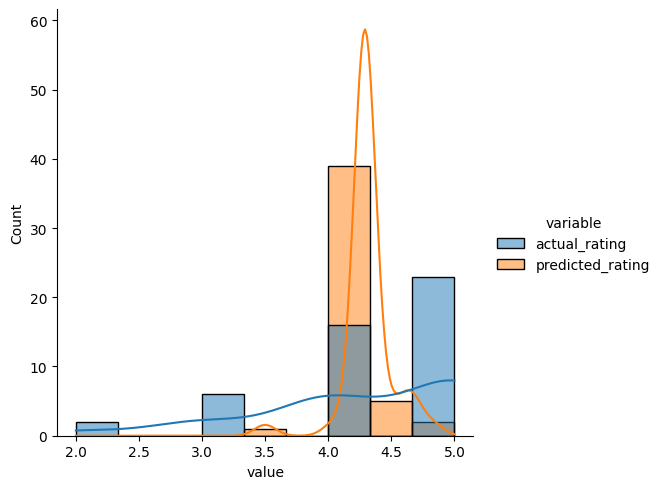

In [61]:
predicted_ratings_for_interacted_items = predict_already_interacted_ratings(df,4, similarity_algo_optimized_user)
data = predicted_ratings_for_interacted_items.melt(id_vars='itemId', value_vars=['actual_rating', 'predicted_rating'])
sns.displot(data=data, x='value', hue='variable', kde=True)

Below we are comparing the predicted ratings by matrix factorization based recommendation system against actual ratings for userId=4

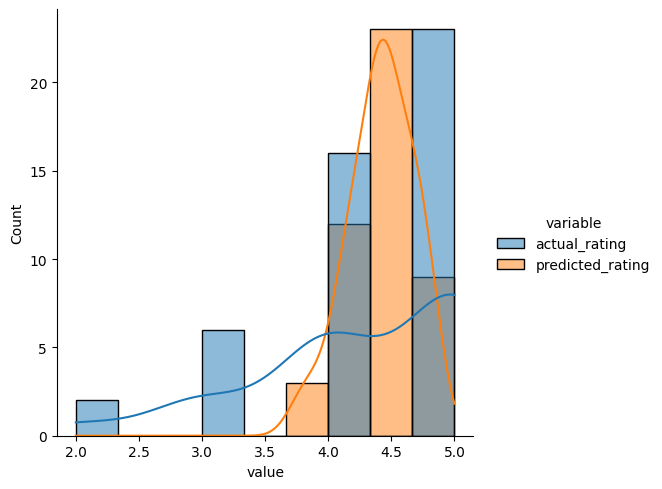

In [62]:
predicted_ratings_for_interacted_items = predict_already_interacted_ratings(df,4, svd_algo_optimized)
data = predicted_ratings_for_interacted_items.melt(id_vars='itemId', value_vars=['actual_rating', 'predicted_rating'])
sns.displot(data=data, x='value', hue='variable', kde=True)

In [63]:
# Instantiating Reader scale with expected rating scale
reader = Reader(rating_scale=(0, 5))

# Loading the rating dataset
data = Dataset.load_from_df(rating[['user_id', 'item_id', 'rating']], reader)

# Splitting the data into train and test dataset
trainset, testset = train_test_split(data, test_size=0.2, random_state=42)

Precision and Recall @ k

RMSE is not the only metric we can use here. We can also examine two fundamental measures, precision and recall. We also add a parameter k which is helpful in understanding problems with multiple rating outputs.

Compute the precision and recall, for each of the 6 models, at k = 5 and 10.

In [64]:
from collections import defaultdict

# Function can be found on surprise documentation FAQs
def precision_recall_at_k(predictions, k=10, threshold=3.5):
    """Return precision and recall at k metrics for each user"""
     # First map the predictions to each user.
    user_est_true = defaultdict(list)
    for uid, _, true_r, est, _ in predictions:
        user_est_true[uid].append((est, true_r))

    precisions = dict()
    recalls = dict()
    for uid, user_ratings in user_est_true.items():
      # Sort user ratings by estimated value
        user_ratings.sort(key=lambda x: x[0], reverse=True)

        # Number of relevant items
        n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)

        # Number of recommended items in top k
        n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])

        # Number of relevant and recommended items in top k
        n_rel_and_rec_k = sum(((true_r >= threshold) and (est >= threshold))
                              for (est, true_r) in user_ratings[:k])

        # Precision@K: Proportion of recommended items that are relevant
        # When n_rec_k is 0, Precision is undefined. We here set it to 0.

        precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 0

        # Recall@K: Proportion of relevant items that are recommended
        # When n_rel is 0, Recall is undefined. We here set it to 0.

        recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 0

    return precisions, recalls

In [65]:
# Make list of k values
# A basic cross-validation iterator.
from surprise.model_selection import KFold
kf = KFold(n_splits=5)
K = [5, 10]

# Make list of models
models = [algo_knn_user, similarity_algo_optimized_user,algo_knn_item,similarity_algo_optimized_item, algo_svd, svd_algo_optimized]


for k in K:
    for model in models:
        print('> k={}, model={}'.format(k,model.__class__.__name__))
        p = []
        r = []
        for trainset, testset in kf.split(data):
            model.fit(trainset)
            predictions = model.test(testset, verbose=False)
            precisions, recalls = precision_recall_at_k(predictions, k=k, threshold=3.5)

            # Precision and recall can then be averaged over all users
            p.append(sum(prec for prec in precisions.values()) / len(precisions))
            r.append(sum(rec for rec in recalls.values()) / len(recalls))
        print('-----> Precision: ', round(sum(p) / len(p), 3))
        print('-----> Recall: ', round(sum(r) / len(r), 3))

> k=5, model=KNNBasic
-----> Precision:  0.867
-----> Recall:  0.685
> k=5, model=KNNBasic
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
-----> Precision:  0.86
-----> Recall:  0.701
> k=5, model=KNNBasic
-----> Precision:  0.834
-----> Recall:  0.659
> k=5, model=KNNBasic
-----> Precision:  0.841
-----> Recall:  0.688
> k=5, model=SVD
-----> Precision:  0.867
-----> Recall:  0.695
> k=5, model=SVD
-----> Precision:  0.871
-----> Recall:  0.695
> k=10, model=KNNBasic
-----> Precision:  0.852
-----> Recall:  0.855
> k=10, model=KNNBasic
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done c

Collaborative Filtering using user-user based interaction performed well in both the k values with Precision value ~84% (k=10) and with k=5, ~86%.

Tuned SVD has better RMSE than all models but Collaborative Filtering using user-user based interaction is also giving good results based on Precsion and recall @k for K=10.

The final model will denpend on the business requirements as whether they have to minimize RMSE or go with maximizing Precision/Recall.